Personal identity identification EDA 

In [3]:
from itertools import chain, compress
from collections import Counter, defaultdict
import string 
import re

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
from nltk.util import ngrams

In [4]:
train = pd.read_json("/kaggle/input/pii-detection-removal-from-educational-data/train.json")
train.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


Text(0.5, 1.0, '% of examples without a single entity')

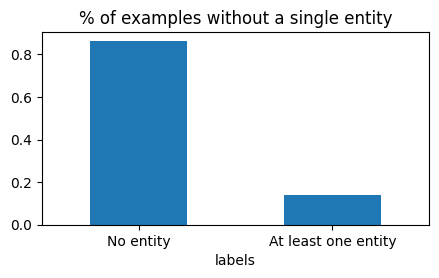

In [7]:

plt.figure(figsize=(5,2.5))
train["labels"].apply(lambda x: "No entity" if set(x)=={'O'} else "At least one entity").value_counts(normalize=True).plot.bar()
plt.xticks(rotation=0)
plt.title('% of examples without a single entity')

In [9]:
# label value counts on the train dataset
labels_chained = chain.from_iterable(train['labels'])
label_counts = Counter(labels_chained)
label_counts


Counter({'O': 4989794,
         'B-NAME_STUDENT': 1365,
         'I-NAME_STUDENT': 1096,
         'B-URL_PERSONAL': 110,
         'B-ID_NUM': 78,
         'B-EMAIL': 39,
         'I-STREET_ADDRESS': 20,
         'I-PHONE_NUM': 15,
         'B-USERNAME': 6,
         'B-PHONE_NUM': 6,
         'B-STREET_ADDRESS': 2,
         'I-URL_PERSONAL': 1,
         'I-ID_NUM': 1})

In [10]:
classes = map(lambda x: x.split("-")[-1], label_counts.keys())
uq_classes = set(classes)
uq_classes



{'EMAIL',
 'ID_NUM',
 'NAME_STUDENT',
 'O',
 'PHONE_NUM',
 'STREET_ADDRESS',
 'URL_PERSONAL',
 'USERNAME'}